In [ ]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
import statistics
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.metrics import f1_score
import torchvision.transforms.functional as functional
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models

In [ ]:
!cp '/content/drive/MyDrive/hackerearth/data.zip' /content/

In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace dataset/test/508.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/test/508.jpg    
replace dataset/test/246.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/246.jpg    
  inflating: dataset/test/473.jpg    
  inflating: dataset/test/485.jpg    
  inflating: dataset/test/128.jpg    
  inflating: dataset/test/410.jpg    
  inflating: dataset/test/465.jpg    
  inflating: dataset/test/196.jpg    
  inflating: dataset/test/340.jpg    
  inflating: dataset/test/467.jpg    
  inflating: dataset/test/306.jpg    
  inflating: dataset/test/171.jpg    
  inflating: dataset/test/323.jpg    
  inflating: dataset/test/332.jpg    
  inflating: dataset/test/330.jpg    
  inflating: dataset/test/170.jpg    
  inflating: dataset/test/479.jpg    
  inflating: dataset/test/9.jpg      
  inflating: dataset/test/283.jpg    
  inflating: dataset/test/114.jpg    
  inflating: dataset/test/507.jpg    
  inflating: dataset/test/183.jpg 

In [ ]:
data_df = pd.read_csv('/content/dataset/train.csv')
data_df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [ ]:
for col in data_df.columns:
  na_count = data_df[col].isna().sum()
  print("nan values count in column {} is {}".format(col, na_count))

nan values count in column Image is 0
nan values count in column target is 0


In [ ]:
dances = ['mohiniyattam', 'odissi', 'bharatanatyam', 'kathakali', 'kuchipudi', 'sattriya', 'kathak', 'manipuri' ]

In [ ]:
def show_images(dataframe, columns=3, rows=5):
  fig = plt.figure(figsize=(10, 10))
  for i in range(1, (columns*rows + 1)):
    img = io.imread('/content/dataset/train/'+ dataframe.iloc[i, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
train_folder = '/content/dataset/train/'

test_folder = '/content/dataset/test/'

In [ ]:
dance_to_number = {'mohiniyattam' : 0, 'odissi' : 1, 'bharatanatyam' : 2, 'kathakali' : 3, 'kuchipudi' : 4, 'sattriya' : 5, 'kathak' : 6, 'manipuri' : 7 }

**Custom Dataset class**

In [ ]:
class IndianDanceDataset(Dataset):
  """
   Args:
            df : Dataframe to be read.
            image_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
  """
  def __init__(self, df, image_folder, transform = None):
    self.dance_df = df
    self.directory = image_folder
    self.transform = transform

  def __len__(self):
    return len(self.dance_df)

  def __getitem__(self, idx):
    
    img_path = os.path.join(self.directory, self.dance_df.iloc[idx, 0])
    dance = self.dance_df.iloc[idx, 1]
    dance = dance_to_number[dance]
    img = io.imread(img_path)

    if self.transform:
      img, dance = self.transform((img, dance))

    return (img, dance)

**Split data_df into train and validation set**

In [ ]:
train_df, validate_df = train_test_split(data_df, test_size=0.1)
print(len(train_df))
print(len(validate_df))

327
37


In [ ]:
# Checking IndianDanceDataset working properly and inspecting values
train_dataset = IndianDanceDataset(df = train_df, image_folder = train_folder)
val_dataset = IndianDanceDataset(df = validate_df, image_folder = train_folder)

In [ ]:
image , label = train_dataset[0]

In [ ]:
print(image.shape)
print(image.dtype)
print(label)

(720, 1280, 3)
uint8
1


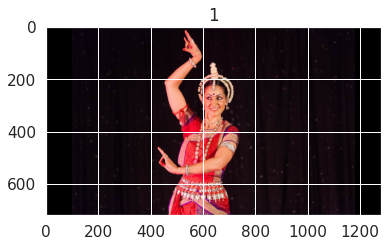

In [ ]:
plt.imshow(image)
plt.title(label)
plt.show()

**Transormations**

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image, dance = sample

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(image, (new_h, new_w))

        return (img,dance)


class ToTensor(object):
  """ rotate image by 40 degree angle

    Args:
        sample : Tuple of image and it's label
    """
  def __call__(self, sample):
    img , dance = sample
    img = img.transpose((2,0,1))
    img = img.astype('float32')
    img = torch.from_numpy(img)
    dance = torch.tensor(dance)
    return (img,dance)

class Normalize(object):
  """ Normalize data with provided mean and std

    Args:
        mean : a list of means of channels 
        std : a list of standard deviations of channels
  """
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, sample):
    img, dance = sample
    img = functional.normalize(img, self.mean, self.std)
    return (img, dance)


**Training with given Dataset**

In [ ]:
batch_size = 32              
# Normalizing data with mean and standard deviations of Imagenet dataset
dance_train = IndianDanceDataset(df = train_df,
                                 image_folder = train_folder,
                                 transform = transforms.Compose([Rescale((224,224)), 
                                                                 ToTensor(),
                                                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

trainloader = DataLoader(dance_train, batch_size = batch_size, shuffle = True)

dance_validate = IndianDanceDataset(df = validate_df,
                                image_folder = train_folder,
                                transform = transforms.Compose([Rescale((224,224)), 
                                                                 ToTensor(),
                                                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

validate_loader = DataLoader(dance_validate, batch_size = batch_size, shuffle = True)

In [ ]:
#inspecting data loader
dataiter = iter(trainloader)
data = dataiter.next()
images , labels = data
print(labels)

print(images[0].shape)
print(labels[0].item())

tensor([1, 3, 4, 3, 7, 5, 7, 3, 6, 6, 5, 3, 0, 4, 1, 4, 4, 2, 3, 1, 6, 1, 5, 0,
        0, 7, 4, 5, 5, 4, 0, 0])
torch.Size([3, 224, 224])
1


In [ ]:
vgg = models.vgg19_bn(pretrained = True)

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# making every parameter to be non trainable
for param in vgg.parameters():
  param.requires_grad = False

In [ ]:
# making only last two dense layers are trainable
vgg.classifier[3] = nn.Linear(4096,4096)
vgg.classifier[6] = nn.Linear(4096,8)

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

*Trying inference*

In [ ]:
outputs = vgg(images)

In [ ]:
outputs

tensor([[ 0.1097, -0.0898, -0.0666, -0.0123,  0.1491,  0.2460, -0.0576,  0.0999],
        [ 0.3230,  0.1920,  0.1505,  0.3567,  0.0293, -0.3645,  0.1313, -0.1388],
        [ 0.2828,  0.1456,  0.1584,  0.1045,  0.2333,  0.4458,  0.0664,  0.0396],
        [ 0.2321, -0.0196,  0.1728, -0.0520,  0.0945, -0.1777,  0.2518, -0.0176],
        [-0.0747, -0.1051,  0.1398, -0.1087,  0.1041, -0.1180,  0.1675, -0.0750],
        [ 0.0983,  0.1522,  0.0417, -0.0136,  0.0792,  0.3205,  0.1374,  0.1458],
        [-0.1147,  0.2243,  0.2035, -0.1309,  0.4656,  0.3099,  0.3228, -0.0283],
        [ 0.3605,  0.1494,  0.2490,  0.1353,  0.0486,  0.1709,  0.1066, -0.1445],
        [ 0.1149, -0.0057,  0.0711, -0.1476,  0.1225, -0.0288,  0.1939,  0.0398],
        [ 0.0219, -0.2066, -0.0654,  0.0887,  0.1172, -0.0806,  0.1991,  0.0214],
        [ 0.4310,  0.1532,  0.0518,  0.2166, -0.0847,  0.0156,  0.0882,  0.0172],
        [ 0.0008, -0.1405, -0.1693, -0.1394,  0.2816,  0.1695,  0.2409, -0.0117],
        [ 0.4211

In [ ]:
del outputs

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg.parameters(), lr=0.001)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    # put model in evaluation mode
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        pred1, labels1 = pred.cpu(), labels.cpu()
        pred1, labels1 = pred1.numpy(), labels1.numpy()
        f1 = f1_score(labels1,pred1,average='micro')
    return [100 * f1, 100 * correct /total]

**Train on Normal Train Data**

In [ ]:
def train(model, trainloader, validate_loader, epochs=5, along_augumented=False, augument_loader=None):
  
  aug_dataiter = None


  loss_train = []
  loss_validate = []
  model_for_epoch = []
  max_epochs = epochs

  train_iters = np.ceil(len(dance_train)/batch_size)
  val_iters = np.ceil(len(dance_validate)/batch_size)

  for epoch in range(max_epochs):
      if along_augumented:
        aug_dataiter = iter(augument_loader)

      loss_epoch_arr = []
      validate_epoch_loss_arr = []
      # train on train-data
      model.train()
      for i, data in enumerate(trainloader, 0):

          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          opt.zero_grad()

          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          opt.step()

          if along_augumented:
            aug_data = aug_dataiter.next()
            aug_inputs, aug_labels = aug_data
            aug_inputs, aug_labels = aug_inputs.to(device), aug_labels.to(device)

            opt.zero_grad()

            aug_outputs = model(aug_inputs)
            aug_loss = loss_fn(aug_outputs, aug_labels)
            aug_loss.backward()
            opt.step()
            del aug_inputs, aug_labels, aug_outputs
            torch.cuda.empty_cache()
            loss = (loss + aug_loss) / 2

          print('Train-dataset : Iteration: %d/%d, Loss: %0.2f' % (i+1, train_iters, loss.item()))
              
          del inputs, labels, outputs
          torch.cuda.empty_cache()
          loss_epoch_arr.append(loss.item())
          
      loss_train.append(statistics.mean(loss_epoch_arr))
      scores = evaluation(trainloader, model)

      if along_augumented:
        validation_scores = evaluation(augument_loader, model)
        scores[0] = (scores[0] + validation_scores[0]) / 2
        scores[1] = (scores[1] + validation_scores[1]) / 2
      
          
      print('Epoch: %d/%d, Train score: %0.2f , Train Acc: %0.2f ' % (epoch+1, max_epochs,scores[0], scores[1]))

      # calculate loss in validation-dataset
      model.eval()
      for i, data in enumerate(validate_loader, 0):

          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)
          loss = loss_fn(outputs, labels)

          print('Validation-dataset : Iteration: %d/%d, Loss: %0.2f' % (i+1, val_iters, loss.item()))
              
          del inputs, labels, outputs
          torch.cuda.empty_cache()
          validate_epoch_loss_arr.append(loss.item())
          
      loss_validate.append(statistics.mean(validate_epoch_loss_arr))
      
      model_for_epoch.append(copy.deepcopy(model))
      
  plt.plot(loss_train)
  plt.plot(loss_validate)
  plt.show()

  return model_for_epoch

Train-dataset : Iteration: 1/11, Loss: 2.10
Train-dataset : Iteration: 2/11, Loss: 2.73
Train-dataset : Iteration: 3/11, Loss: 2.18
Train-dataset : Iteration: 4/11, Loss: 2.09
Train-dataset : Iteration: 5/11, Loss: 1.91
Train-dataset : Iteration: 6/11, Loss: 1.77
Train-dataset : Iteration: 7/11, Loss: 2.31
Train-dataset : Iteration: 8/11, Loss: 1.66
Train-dataset : Iteration: 9/11, Loss: 1.43
Train-dataset : Iteration: 10/11, Loss: 1.01
Train-dataset : Iteration: 11/11, Loss: 0.65
Epoch: 1/5, Train score: 85.71 , Train Acc: 75.54 
Validation-dataset : Iteration: 1/2, Loss: 1.24
Validation-dataset : Iteration: 2/2, Loss: 1.01
Train-dataset : Iteration: 1/11, Loss: 0.92
Train-dataset : Iteration: 2/11, Loss: 1.08
Train-dataset : Iteration: 3/11, Loss: 0.87
Train-dataset : Iteration: 4/11, Loss: 0.54
Train-dataset : Iteration: 5/11, Loss: 0.58
Train-dataset : Iteration: 6/11, Loss: 0.53
Train-dataset : Iteration: 7/11, Loss: 0.74
Train-dataset : Iteration: 8/11, Loss: 0.57
Train-dataset :

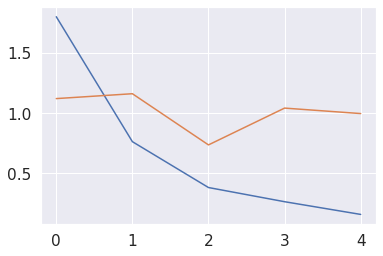

In [ ]:
model_for_epoch = train(vgg, trainloader, validate_loader)

**Tracking wrong predictions**

In [ ]:
class Inspect_IndianDanceDataset(Dataset):
  """
   Args:
            df : Dataframe to be read.
            image_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.

            returns a tuple (image, dance, image_filename)
  """
  def __init__(self, df, image_folder, transform = None):
    self.dance_df = df
    self.directory = image_folder
    self.transform = transform

  def __len__(self):
    return len(self.dance_df)

  def __getitem__(self,idx):
    
    img_path = os.path.join(self.directory,self.dance_df.iloc[idx,0])
    dance = self.dance_df.iloc[idx,1]
    dance = dance_to_number[dance]
    img = io.imread(img_path)
    img_name = self.dance_df.iloc[idx,0]

    if self.transform:
      img,dance = self.transform((img,dance))

    return (img, dance, img_name)


In [ ]:
# taking entire validation dataset and checking wrong predictions

dance_train_test = Inspect_IndianDanceDataset(df = validate_df,
                                 image_folder = train_folder,
                                 transform = transforms.Compose([Rescale((224,224)),
                                                                 ToTensor(),
                                                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

inspect_dataloader = DataLoader(dance_train_test, batch_size = 1, shuffle = False)

In [ ]:
def inspect_data(dataloader, model):
  actuals = []
  predicts = []
  for data in dataloader :
    inputs , org_dance_no, img_name = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)

    pred_dance = number_to_dance[pred.item()]
    actual_dance = number_to_dance[org_dance_no.item()]

    actuals.append(actual_dance)
    predicts.append(pred_dance)

    if pred_dance != actual_dance:
      print('Predicted: ',pred_dance,',    Actual: ',actual_dance, ',  image Name: ',img_name[0])
    
  return actuals, predicts


In [ ]:
number_to_dance = {0 :'mohiniyattam', 1 :'odissi', 2 :'bharatanatyam', 3 : 'kathakali' ,
                   4 : 'kuchipudi', 5 : 'sattriya', 6 : 'kathak' , 7 : 'manipuri'}

In [ ]:
# taking best_epoch for inspecting

model_to_test = model_for_epoch[2]
y_true, y_pred = inspect_data(inspect_dataloader, model_to_test)

Predicted:  mohiniyattam ,    Actual:  odissi ,  image Name:  489.jpg
Predicted:  kuchipudi ,    Actual:  bharatanatyam ,  image Name:  168.jpg
Predicted:  odissi ,    Actual:  bharatanatyam ,  image Name:  120.jpg


In [ ]:
print(*dances)
cm = confusion_matrix(y_true, y_pred, labels = dances)

mohiniyattam odissi bharatanatyam kathakali kuchipudi sattriya kathak manipuri


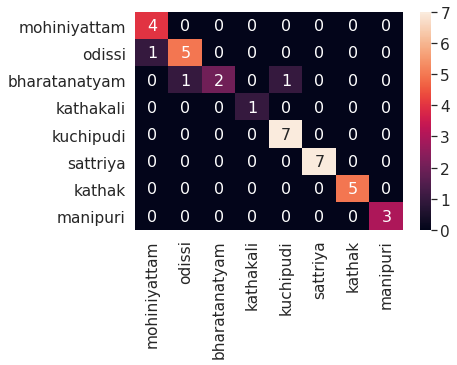

In [ ]:
df_cm = pd.DataFrame(cm, dances, dances)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

**Train Along with augumented Data**

In [ ]:
class Rotate(object):
  """ rotate image by 40 degree angle

    Args:
        sample : Tuple of image and it's label
    """
  def __call__(self, sample):
    img, dance = sample
    img = skimage.transform.rotate(img,angle = 40, mode='wrap')
    
    return (img,dance)


class Flip_and_ToTensor(object):
  """ Flip image horizontally and transform to tensor

    Args:
        sample : Tuple of image and it's label
    """
  def __call__(self, sample):
    img , dance = sample

    img = np.fliplr(img)  #horizontal flip of image
    
    #transform to Tensor
    img = img.transpose((2,0,1))
    img = img.astype('float32')
    img = torch.from_numpy(img)
    dance = torch.tensor(dance)
    return (img,dance)

In [ ]:
# Actual Data
batch_size = 32              
dance_train = IndianDanceDataset(df = train_df,
                                 image_folder = train_folder,
                                 transform = transforms.Compose([Rescale((224,224)), 
                                                                 ToTensor(),
                                                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

trainloader = DataLoader(dance_train, batch_size = batch_size, shuffle = True)

dance_validate = IndianDanceDataset(df = validate_df,
                                image_folder = train_folder,
                                transform = transforms.Compose([Rescale((224,224)), 
                                                                 ToTensor(),
                                                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

validate_loader = DataLoader(dance_validate, batch_size = batch_size, shuffle = True)

In [ ]:
# Augumented Data
augumented_dance_train = IndianDanceDataset(df = train_df,
                                 image_folder = train_folder,
                                 transform = transforms.Compose([Rescale((224,224)), 
                                                                 Flip_and_ToTensor(),
                                                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

augumented_trainloader = DataLoader(augumented_dance_train, batch_size = batch_size, shuffle = True)

In [ ]:
vgg_2 = models.vgg19_bn(pretrained = True)

In [ ]:
# making every parameter to be non trainable
for param in vgg_2.parameters():
  param.requires_grad = False

# making only last two layers as trainable
vgg_2.classifier[3] = nn.Linear(4096,4096)
vgg_2.classifier[6] = nn.Linear(4096,8)

In [ ]:
vgg_2 = vgg_2.to(device)
loss_fn = nn.CrossEntropyLoss() 
opt = optim.Adam(vgg_2.parameters(), lr=0.001) # adam optimizer

Train-dataset : Iteration: 1/11, Loss: 2.10
Train-dataset : Iteration: 2/11, Loss: 1.70
Train-dataset : Iteration: 3/11, Loss: 1.46
Train-dataset : Iteration: 4/11, Loss: 1.18
Train-dataset : Iteration: 5/11, Loss: 1.24
Train-dataset : Iteration: 6/11, Loss: 1.11
Train-dataset : Iteration: 7/11, Loss: 1.05
Train-dataset : Iteration: 8/11, Loss: 0.79
Train-dataset : Iteration: 9/11, Loss: 0.93
Train-dataset : Iteration: 10/11, Loss: 0.51
Train-dataset : Iteration: 11/11, Loss: 1.03
Epoch: 1/3, Train score: 71.43 , Train Acc: 81.35 
Validation-dataset : Iteration: 1/2, Loss: 1.48
Validation-dataset : Iteration: 2/2, Loss: 2.19
Train-dataset : Iteration: 1/11, Loss: 0.47
Train-dataset : Iteration: 2/11, Loss: 0.27
Train-dataset : Iteration: 3/11, Loss: 0.45
Train-dataset : Iteration: 4/11, Loss: 0.33
Train-dataset : Iteration: 5/11, Loss: 0.37
Train-dataset : Iteration: 6/11, Loss: 0.26
Train-dataset : Iteration: 7/11, Loss: 0.23
Train-dataset : Iteration: 8/11, Loss: 0.20
Train-dataset :

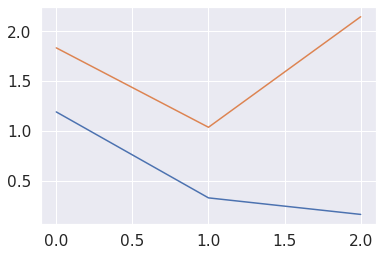

In [ ]:
aug_model_for_epoch = train(vgg_2,trainloader=augumented_trainloader, validate_loader=validate_loader, epochs=3, along_augumented=True, augument_loader=augumented_trainloader)

In [ ]:
aug_model_to_test = aug_model_for_epoch[1]

**Track wrong predictions in valiation set using model trained on Augumented data**

In [ ]:
y_true, y_pred = inspect_data(inspect_dataloader, aug_model_to_test)

Predicted:  mohiniyattam ,    Actual:  odissi ,  image Name:  489.jpg
Predicted:  odissi ,    Actual:  sattriya ,  image Name:  333.jpg
Predicted:  odissi ,    Actual:  manipuri ,  image Name:  87.jpg
Predicted:  odissi ,    Actual:  kuchipudi ,  image Name:  442.jpg
Predicted:  odissi ,    Actual:  bharatanatyam ,  image Name:  120.jpg


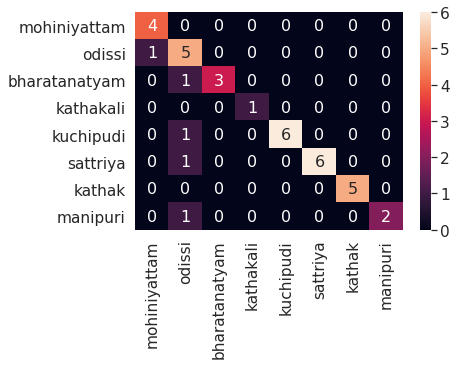

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels = dances)
df_cm = pd.DataFrame(cm, dances, dances)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# **Conclusion**
Both models trained on actual and augumented d ata having same performance on validation set and both are pretty good

**Testing with test data**

In [ ]:
class testDataset(Dataset):
  """
   Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
  """
  def __init__(self, csv_path, image_folder, transform = None):
    self.dance_df = pd.read_csv(csv_path)
    self.directory = image_folder
    self.transform = transform

  def __len__(self):
    return len(self.dance_df)

  def __getitem__(self,idx):
    
    img_name = self.dance_df.iloc[idx,0]
    img_path = os.path.join(self.directory,self.dance_df.iloc[idx,0])
    img = io.imread(img_path)

    if self.transform:
      img = self.transform(img)

    return (img,img_name)


In [ ]:
class TestRescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, image):
        imge = image

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(imge, (new_h, new_w))

        return img


class TestToTensor(object):
  def __call__(self,image):
    img  = image
    img = img.transpose((2,0,1))
    img = img.astype('float32')
    img = torch.from_numpy(img)
    
    return img

class TestNormalize(object):

  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self,image):
    return functional.normalize(image, self.mean, self.std)


In [ ]:
test_dataset = testDataset('/content/dataset/test.csv', test_folder,
                        transform = transforms.Compose([TestRescale((224,224)),
                                                        TestToTensor(),
                                                        TestNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

testloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [ ]:
for i, data in enumerate(testloader):
  print(data[0].shape)
  if i == 2:
    break

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
def test(testloader,model):
  names = []
  ans = []
  for data in testloader :
    inputs , name = data
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)

    names.append(name[0])
    dance = number_to_dance[pred.item()]

    print(name[0] , dance)
    ans.append(dance)
  
  data = {'Image': names , 'target': ans}
  df = pd.DataFrame(data)

  return df


In [ ]:
# taking epoch 1 model because it has lower gap between train and validate loss
model_to_test = aug_model_for_epoch[1]
test_predictions = test(testloader, model_to_test)

508.jpg kathak
246.jpg mohiniyattam
473.jpg odissi
485.jpg odissi
128.jpg bharatanatyam
410.jpg kathak
465.jpg kuchipudi
196.jpg kathakali
340.jpg sattriya
467.jpg sattriya
306.jpg mohiniyattam
171.jpg bharatanatyam
323.jpg sattriya
332.jpg sattriya
330.jpg sattriya
170.jpg bharatanatyam
479.jpg odissi
9.jpg kathak
283.jpg mohiniyattam
114.jpg bharatanatyam
507.jpg kuchipudi
183.jpg kathakali
200.jpg kathakali
457.jpg sattriya
264.jpg mohiniyattam
194.jpg kathakali
518.jpg odissi
175.jpg bharatanatyam
64.jpg kathak
152.jpg sattriya
270.jpg mohiniyattam
125.jpg kuchipudi
38.jpg kathak
440.jpg bharatanatyam
302.jpg mohiniyattam
394.jpg kuchipudi
448.jpg odissi
463.jpg odissi
20.jpg kathak
301.jpg odissi
28.jpg kathak
61.jpg kathak
398.jpg kuchipudi
349.jpg sattriya
271.jpg mohiniyattam
286.jpg sattriya
431.jpg manipuri
316.jpg sattriya
224.jpg kathakali
411.jpg kuchipudi
278.jpg mohiniyattam
456.jpg sattriya
45.jpg kathak
324.jpg sattriya
6.jpg kathak
59.jpg sattriya
86.jpg manipuri
470.

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "test-predictions.csv"):  
    csv = df.to_csv(index = False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)



In [ ]:
create_download_link(test_predictions)